In [ ]:
# 필요한 모듈 import하기

from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import optimizers


from glob import glob
from pprint import pprint

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

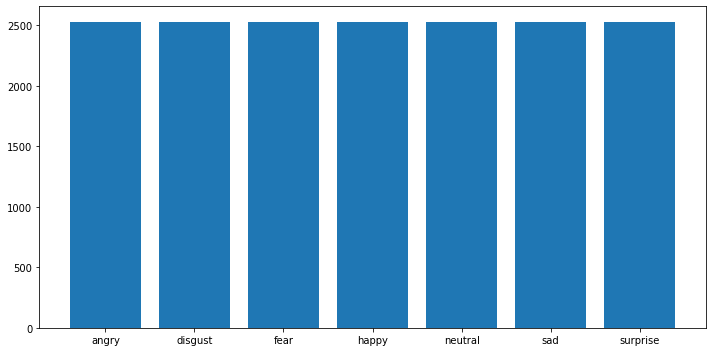

In [ ]:
csv_path = './feelings_skfold2.csv'
df = pd.read_csv(csv_path)
np.unique(df['emotion'])

value_counts = df['emotion'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

# 1. Model 정의하기

* binary crossentropy : binary 다중 분류 손실 함수 -> label들이 독립적일 때 사용함
* categorical_crossentropy : 다중 분류 손실 함수, 출력값이 one-hot encoding된 결과로 나옴
* (정답에만 1으로 표시하고, 나머지는 0으로)
* 각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
* sparse_categorical_crossentropy : 다중 분류 손실 함수, one - hot - encoding을 하지 않고 정수 형태로 넣어줌, 한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

* softmax
- 출력은 0 ~ 1 사이의 실수
- 출력을 확률로 해석할 수 있음
- 출력의 총합은 1이다.

In [ ]:
def get_model(input_shape):
    
    model = keras.Sequential(
        [
            # input
            layers.Input(input_shape),
            
            # 1번쨰 layer
            layers.Conv2D(64,(3,3),strides = 1,activation = "relu",padding = 'same'), 
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size = (2,2)),
            layers.Dropout(0.25),
            
            # 2번쨰 layer
            layers.Conv2D(128,(5,5),strides = 1,activation = "relu",padding = 'same'), 
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size = (2,2)),
            layers.Dropout(0.25),
            
            # 3번쨰 layer
            layers.Conv2D(512,(3,3),strides = 1,activation = "relu",padding = 'same'), 
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size = (2,2)),
            layers.Dropout(0.25),
            
            # 4번쨰 layer
            layers.Conv2D(512,(3,3),strides = 1,activation = "relu",padding = 'same'), 
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size = (2,2)),
            layers.Dropout(0.25),
            
            layers.Flatten(),
            
            # 연결된 첫 번째 layer
            layers.Dense(256,activation = "relu"), 
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            
            # 연결된 두 번째 layer
            layers.Dense(512,activation = "relu"), 
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            
            # Classifier
            layers.Dense(7,activation = "softmax")
        ]
    )

    return model

In [ ]:
input_shape = (48,48,1)    
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr = 0.0001)

model.compile(
    optimizer = adam,
    loss = 'categorical_crossentropy', # 다중 분류 손실 함수
    metrics = 'accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import albumentations as A

# Albumentation class 생성하기
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평 전환
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8, # 최대 8개의 구멍을 dropout 시킴
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # callback 함수: 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image'] # 증폭된 이미지
            return img 

In [ ]:
csv_path = './feelings_skfold2.csv'

LABEL_INT_DICT = np.unique(pd.read_csv(csv_path)['emotion'])
pprint(LABEL_INT_DICT) # 데이터의 타입과 형태 등도 같이 보여준다.(조금 더 예쁘게 출력해준다?)
print("===================================")

LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)
print("===================================")

# 원-핫 인코딩의 형태로 emotion(label)의 형태 변경(딕셔너리의 key 변경)
# 원-핫 인토딩 어케 쓰는지 까먹어서...형태 걍 만들었습니다....^-^;

LABEL_STR_DICT['angry'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['disgust'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['fear'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['happy'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['neutral'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['sad'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['surprise'] = [1,0,0,0,0,0,0]
pprint(LABEL_STR_DICT)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}
{'angry': [1, 0, 0, 0, 0, 0, 0],
 'disgust': [1, 0, 0, 0, 0, 0, 0],
 'fear': [1, 0, 0, 0, 0, 0, 0],
 'happy': [1, 0, 0, 0, 0, 0, 0],
 'neutral': [1, 0, 0, 0, 0, 0, 0],
 'sad': [1, 0, 0, 0, 0, 0, 0],
 'surprise': [1, 0, 0, 0, 0, 0, 0]}


In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle: # shuffle = True라면(df 앞의 인덱스를 지워주는 기능
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    # len()
    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            img_folder = r['emotion'] # type = np.str_

            image = cv2.imread(f'datasets/{img_folder}/{file_name}.jpg',cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8') # 정수로 형변환
                image = self.transform(image=image)

            image = image.astype('float32') # 실수로 다시 형변환         
            image = image / 255.

            
            emotion = str(img_folder)
            emotion = LABEL_STR_DICT[emotion]
            
            batch_x.append(image)
            batch_y.append(emotion)
        
        return batch_x, batch_y
    

In [ ]:
csv_path = './feelings_skfold2.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 50,
    verbose = 1
)

Epoch 1/50


UnimplementedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2833, in run_cell
      result = self._run_cell(
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2879, in _run_cell
      return runner(coro)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3280, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3340, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\doroc\AppData\Local\Temp\ipykernel_15008\4162541532.py", line 1, in <cell line: 1>
      history = model.fit(
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\layers\convolutional.py", line 275, in call
      return self.activation(outputs)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py", line 4956, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_train_function_2368]

In [ ]:
history = history.history

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()